In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.932722,0.806913,0.653998,0.860533,0.837016,1.0,0.550415,0.000000,0.778617,0.940755
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.692339,0.578107,0.619998,0.0,0.000000,0.000000,0.607899,0.206271
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.000000,0.505180,0.644769,0.603195,0.756754,0.0,0.350566,0.000000,0.899508,0.014040
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.000000,0.000000,0.131632,0.053179,0.774455,0.0,0.000000,0.000000,0.528882,0.305806
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.000000,0.000000,0.085440,0.761822,0.860355,0.0,0.000000,0.000000,0.604102,0.014040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.000000,0.000000,0.149005,0.740343,0.641698,0.0,0.000000,0.694951,0.485461,0.300471
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.000000,0.000000,0.229358,0.640000,0.731908,0.0,0.422815,0.096205,0.502320,0.615334
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.000000,0.000000,0.211405,0.797333,0.896369,0.0,0.234352,0.000000,0.496177,0.402714


In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.00000,0.0,0.016890,0.754178,0.816832,0.0,0.214180,0.000000,0.627881,0.014040
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.00000,0.0,0.380373,0.659297,0.789071,0.0,0.000000,0.296100,0.763348,0.354178
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.68115,0.0,0.127947,1.009412,0.582660,0.0,0.000000,0.473139,0.277717,0.014040
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.00000,0.0,0.203518,0.723574,0.696147,0.0,0.000000,0.000000,0.646765,0.450394
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.00000,0.0,0.214416,0.496175,0.803259,0.0,0.236722,0.000000,0.534480,0.304870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.00000,0.0,0.357494,0.782257,0.591442,0.0,0.000000,0.431213,0.465159,0.540147
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.00000,0.0,0.418615,0.949858,0.559052,0.0,0.269991,0.410777,0.361163,0.561191
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.00000,0.0,0.105689,0.683222,0.878635,0.0,0.182111,0.650452,0.568842,0.398252


In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
# compound_model = keras.models.load_model('cd_clf')

In [7]:
# compound_model.summary()

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [9]:
import objects

In [10]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True)

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


link.f
link.f
link.f
link.f


## Calculate SHAP values

In [11]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [12]:
# shap_values

## Save SHAP values

In [13]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [14]:


with open("../data/models/shap/all_dep_2p11_2p5", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [15]:
shap_values = shap_values[0]


In [16]:
# for i in range(3):
#     shap_values[i] /= 100

In [17]:
shap_values

[array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,  10.35681313],
        [  2.31411475,  -3.01306998,   0.        , ...,   0.        ,
          -3.36040001,   0.        ],
        [ 30.06861023,   0.        , -10.58863855, ...,  -6.876709  ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   1.06498791,   0.        , ...,  -4.89882368,
          -1.3523622 ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,  -2.20751166,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   1.36594205, ...,  -0.97841846,
          -1.65414425,   1.58354946]]),
 array([[  0.        ,  13.39938482, -14.22156879, ...,   0.        ,
          11.89909282,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,


In [18]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 221)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [19]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.0,0.0,0.155668,0.723766,0.785738,0.0,0.0,0.236732,0.678505,0.727315


In [20]:
gmm_model_get_prediction_ae(patient)[0]

array([2.10208717e-56, 1.38514946e-01, 8.61485054e-01])

In [21]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.10208717e-56 1.38514946e-01 8.61485054e-01]
Predicted class: 2


#### Control

In [22]:
import shap

In [23]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [24]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [25]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [26]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

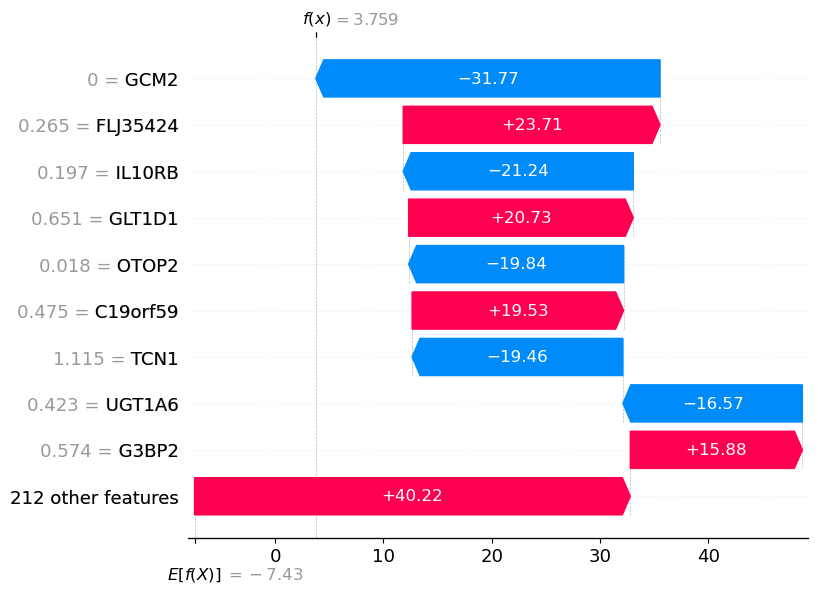

In [27]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [28]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [29]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [30]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

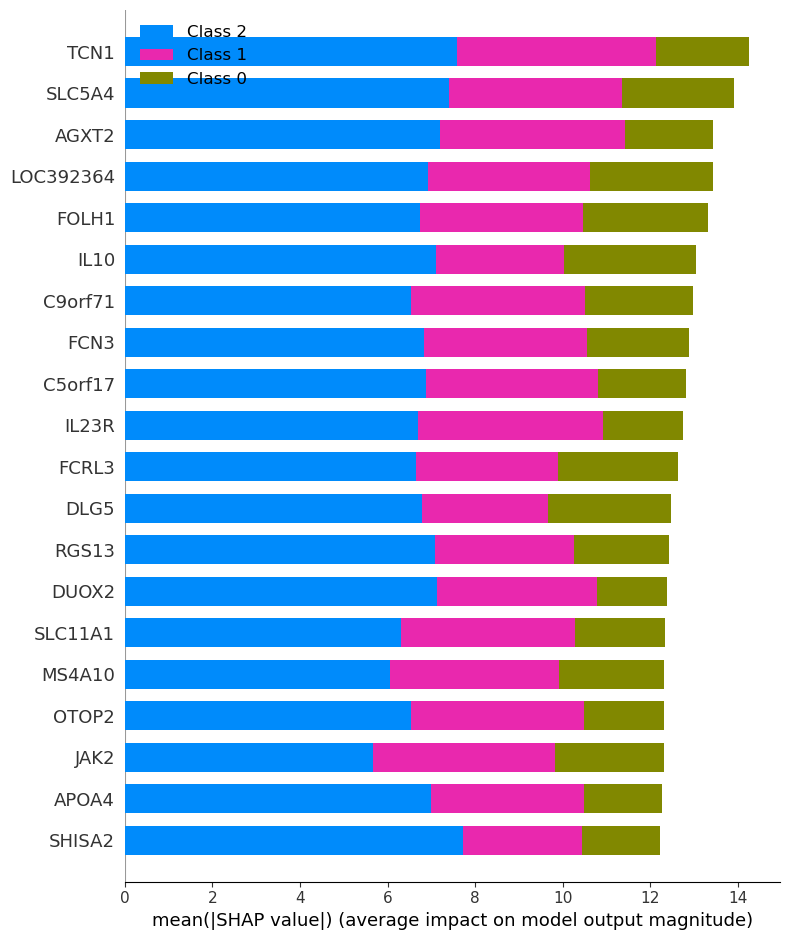

In [31]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


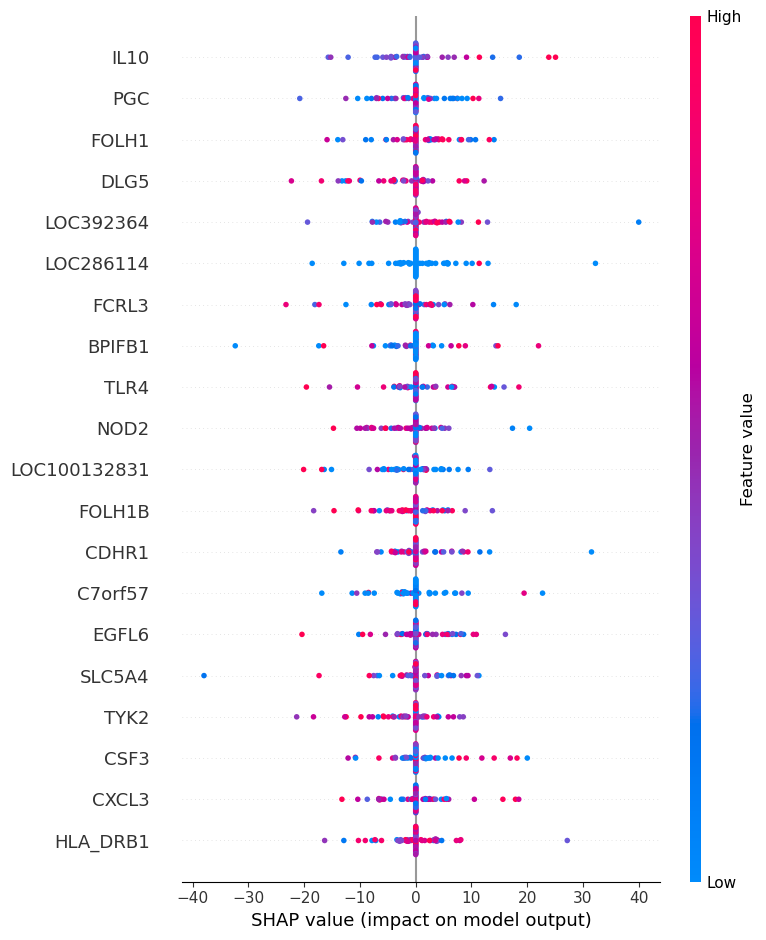

In [32]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

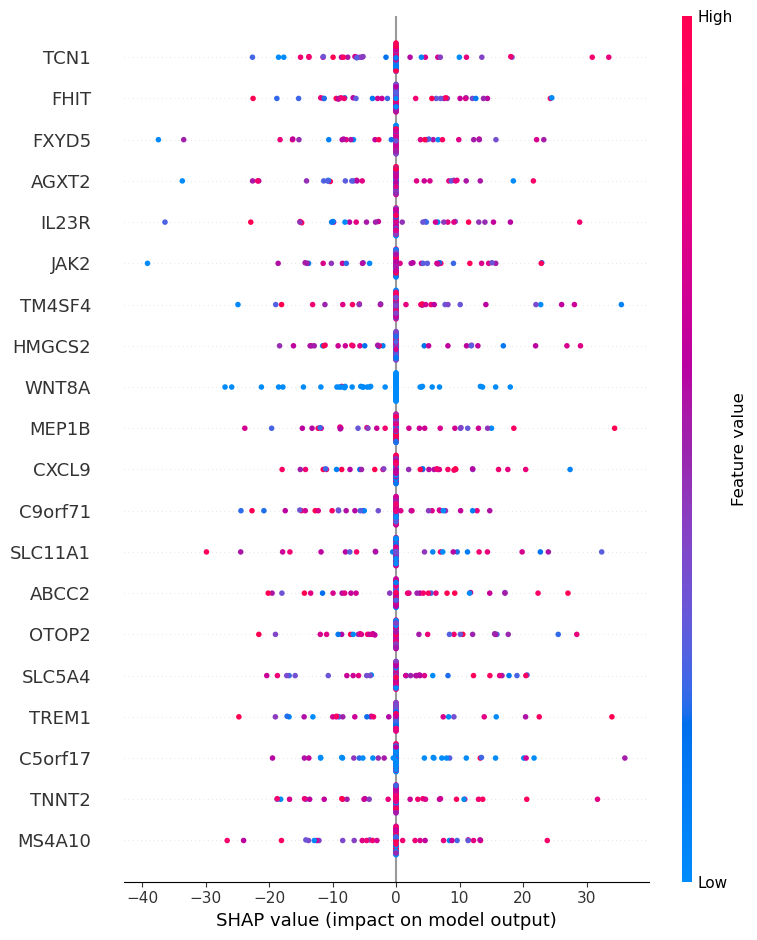

In [33]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

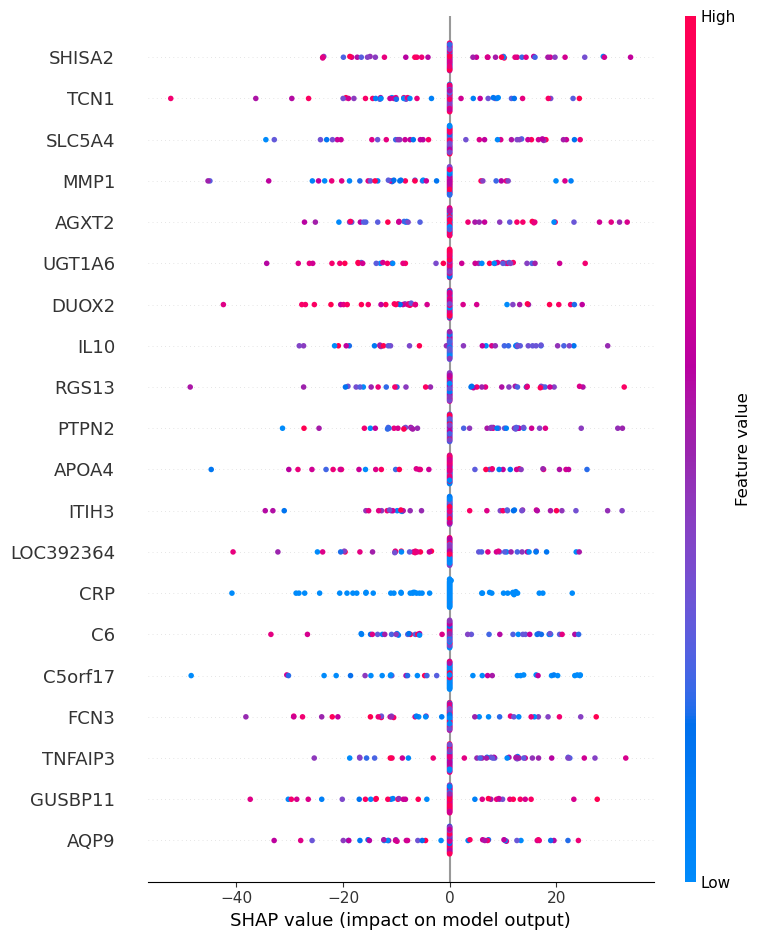

In [34]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

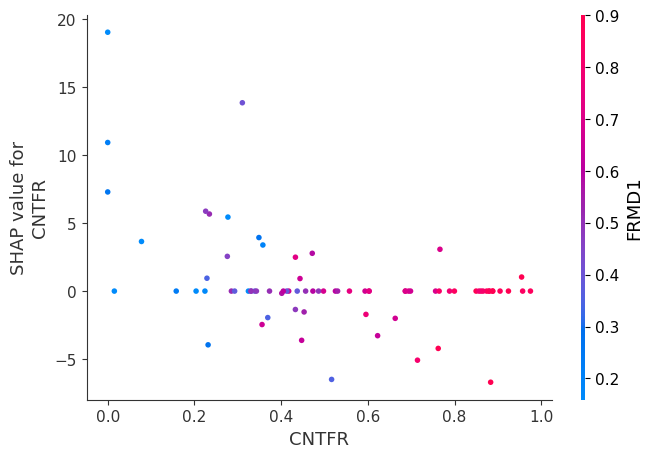

In [35]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

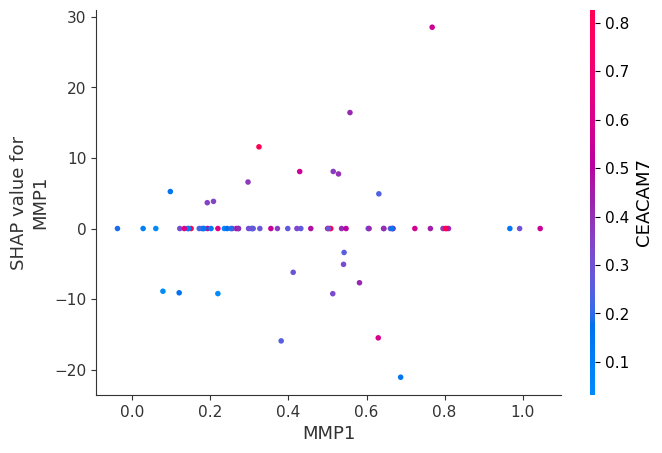

In [36]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

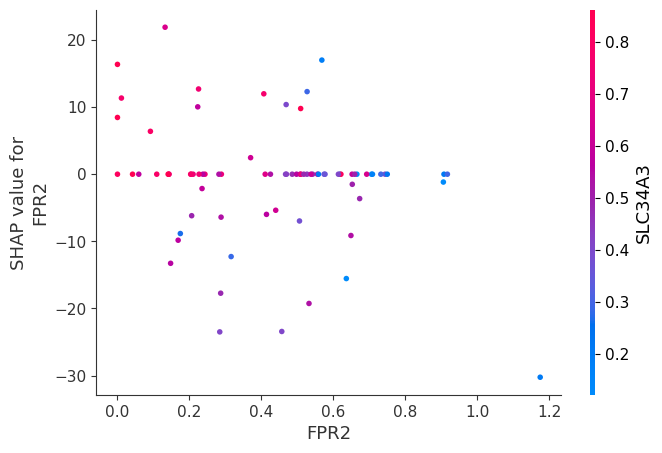

In [37]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [38]:
disease_labels_test.shape

(78,)

In [39]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [40]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 96%|█████████████████████████████████████████████████████████████████████████████   | 213/221 [01:29<00:02,  2.87it/s]No/low signal found from feature 212 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
222it [01:33,  2.12it/s]                                                                                               


In [41]:
# clustering

In [42]:
# clustering.shape

In [43]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [44]:
type(exp)

shap._explanation.Explanation

In [45]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [46]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

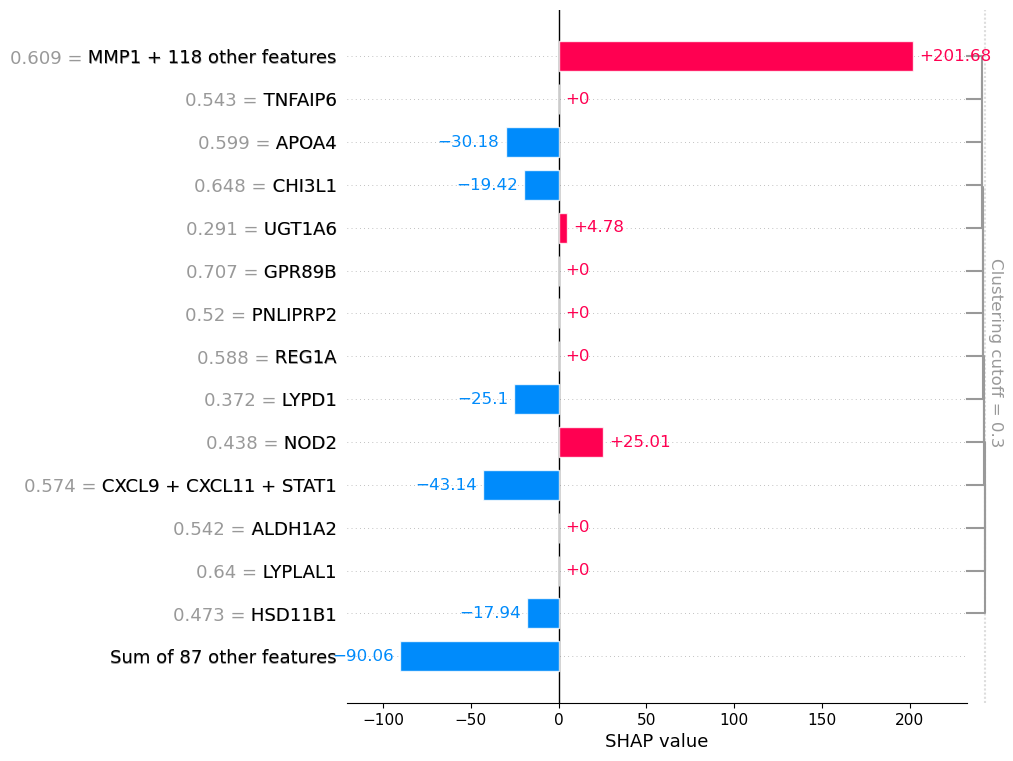

In [47]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [49]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.543266
167_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,24.162896,-9.611500,-10.437742,-14.739718,-3.851645,...,0.000000,0.000000,0.000000,6.023769,-16.954552,0.000000,0.000000,0.000000,12.694188,0.000000
196_CD_deep_ulcer,0.000000,-22.194636,0.000000,0.000000,-13.619960,0.000000,12.886021,0.000000,0.000000,10.619857,...,0.000000,0.000000,0.000000,12.499454,-9.530881,0.000000,0.000000,0.000000,0.000000,15.738527
23_CD_deep_ulcer,0.000000,15.064395,13.416470,-13.965826,0.608347,-7.892106,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,10.925630,7.739343,8.920585,0.000000,6.741904,7.456455,-12.312687
93_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,-7.728925,10.199747,0.000000,0.000000,0.000000,0.000000,...,5.232611,7.774086,0.000000,9.444442,0.000000,0.000000,0.000000,14.658990,0.000000,0.000000
229_CD_deep_ulcer,0.000000,14.950587,-25.833225,-17.677842,17.830104,16.814669,18.682169,0.000000,0.000000,0.000000,...,0.000000,-23.021374,0.000000,0.000000,-13.870584,0.000000,6.123712,-4.497451,8.542488,13.441905
46_CD_deep_ulcer,9.920850,0.000000,11.381748,0.000000,0.000000,0.000000,0.000000,-13.761228,0.000000,-7.514596,...,0.000000,9.329818,0.000000,0.000000,0.000000,9.955067,0.000000,-15.575901,0.000000,0.000000
176_CD_deep_ulcer,6.203274,0.000000,0.000000,-8.315774,0.000000,6.201614,4.077871,0.000000,-7.774138,0.000000,...,-12.017277,6.711746,0.000000,0.000000,0.000000,0.000000,12.715420,0.000000,14.863168,0.000000
49_CD_deep_ulcer,0.000000,8.508184,-44.737648,19.519609,0.000000,7.294012,-7.858066,11.918741,0.000000,-4.160915,...,-4.667034,2.478705,-11.587372,0.000000,-37.416562,13.358648,-4.687131,0.000000,0.000000,0.000000


### Example: CD deep ulcer patients

In [50]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

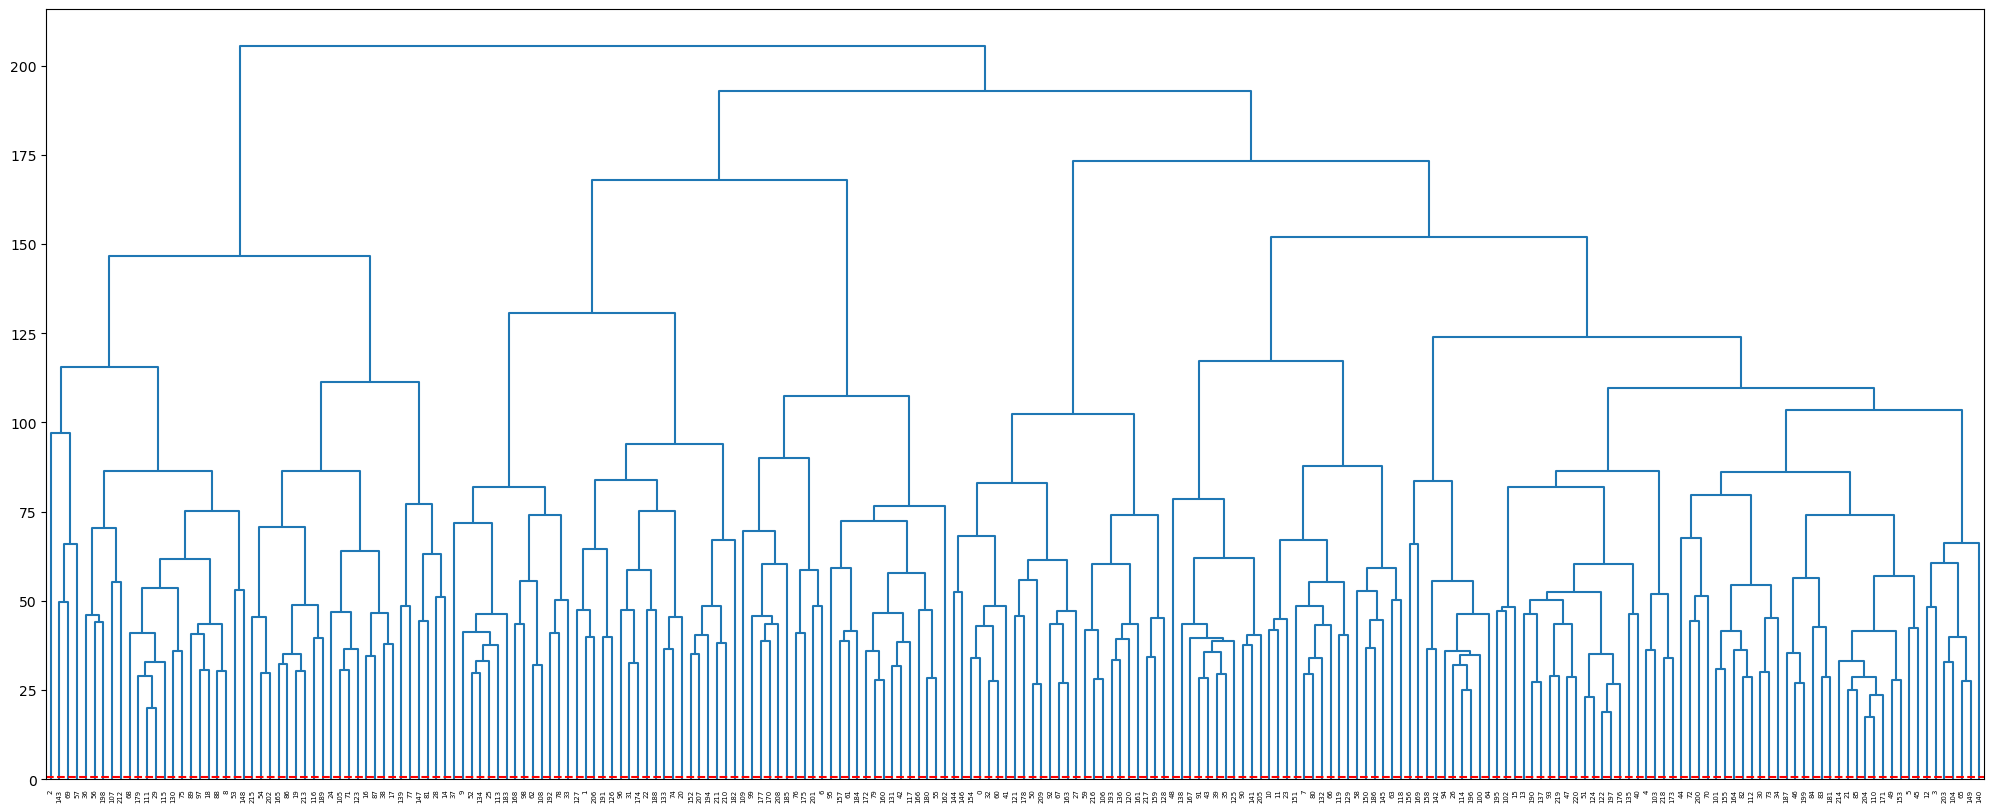

In [51]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [52]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([  2, 143,  69,  57,  36,  56, 198, 107, 212,  68, 179, 111,  29,
       115, 130,  75,  89,  97,  18,  88,   8,  53, 148, 215,  54, 202,
       165,  86,  19, 213, 116, 189,  24, 105,  71, 123,  16,  87,  38,
        17, 139,  77, 147,  81,  28,  14,  37,   9,  52, 134,  25, 113,
       183, 168,  98,  62, 108, 192,  78,  33, 127,   1, 206, 191, 126,
        96,  31, 174,  22, 188, 133,  74,  20, 152, 207, 194, 211, 210,
       182, 109,  99, 177, 170, 208, 185,  76, 175, 201,   6,  95, 157,
        61, 184, 172,  79, 160, 131,  42, 117, 166, 180,  55, 162, 144,
       146, 154,   0,  32,  60,  41, 121, 178,  50, 209,  92,  67, 163,
        27,  59, 216, 106, 193, 136, 120, 161, 217, 159, 128,  48, 138,
       167,  91,  43,  39,  35, 125,  90, 141, 205,  10,  11,  23, 151,
         7,  80, 132,  66, 119, 129,  58, 150, 186, 145,  63, 118, 156,
       169, 158, 142,  94,  26, 114, 196, 100,  64, 195, 102,  15,  13,
       190, 137,  93, 219,  47, 220,  51, 124, 122, 197, 176, 13

In [53]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'PPP1R17', 'WNT8A', 'LSM5', 'PCDHB3', 'GUSBP11', 'C16orf78', 'C5orf17',
       'LOC100132831', 'LOC100288778', 'LOC100505851'],
      dtype='object', length=221)

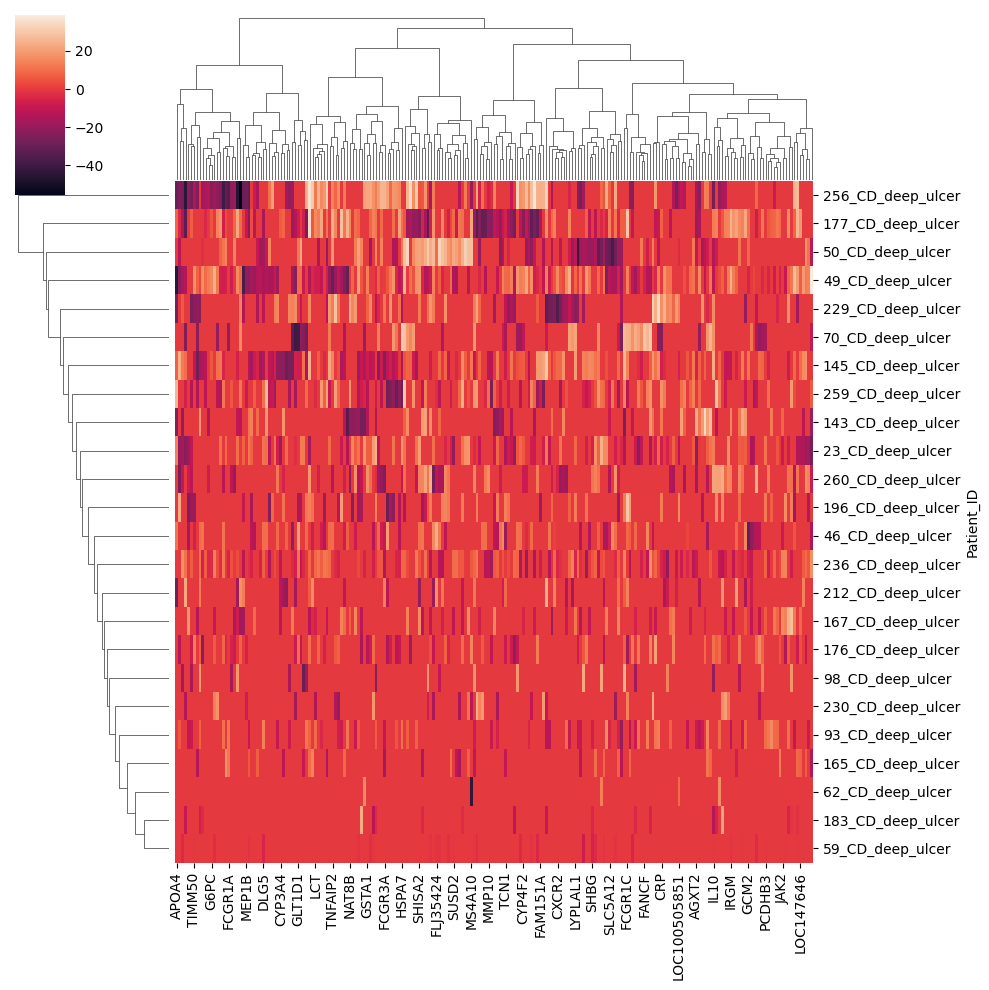

In [54]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [55]:
gene_cluster_cd_deep

array([[204.        , 110.        ,  17.31230597,   2.        ],
       [122.        , 197.        ,  18.74313644,   2.        ],
       [111.        ,  29.        ,  19.8548895 ,   2.        ],
       [ 51.        , 124.        ,  22.89631212,   2.        ],
       [221.        , 171.        ,  23.5551523 ,   3.        ],
       [114.        , 196.        ,  24.88515663,   2.        ],
       [ 21.        ,  85.        ,  24.9870428 ,   2.        ],
       [ 50.        , 209.        ,  26.57762308,   2.        ],
       [222.        , 176.        ,  26.71692496,   3.        ],
       [ 46.        , 199.        ,  26.85513145,   2.        ],
       [ 67.        , 163.        ,  26.95787875,   2.        ],
       [190.        , 137.        ,  27.25387632,   2.        ],
       [ 32.        ,  60.        ,  27.38918319,   2.        ],
       [ 65.        , 149.        ,  27.56150351,   2.        ],
       [ 79.        , 160.        ,  27.84424609,   2.        ],
       [ 49.        , 153

In [56]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(221,)

In [57]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([143,  69,  57,   2,  56, 198,  36, 107, 212, 111,  29, 179, 115,
         68, 130,  75,  97,  18,  89,  88,   8,  53, 148,  54, 202, 215,
        165,  86,  19, 213, 116, 189, 105,  71, 123,  24,  16,  87,  38,
         17, 139,  77, 147,  81,  28,  14,  52, 134,  25, 113,   9, 183,
         37, 168,  98,  62, 108, 192,  78,  33,   1, 206, 127, 191, 126,
         31, 174,  96,  22, 188, 133,  74,  20, 152, 207, 194, 211, 210,
        182, 177, 170, 208,  99, 185, 109,  76, 175, 201,   6, 157,  61,
        184,  95,  79, 160, 172, 131,  42, 117, 180,  55, 166, 162, 144,
        146, 154,   0,  32,  60,  41, 121, 178,  50, 209,  67, 163,  92,
         27, 216, 106,  59, 193, 136, 120, 161, 217, 159, 128,  91,  43,
         39,  35, 125, 167, 138,  90, 141, 205,  48,  10,  11,  23,   7,
         80, 132,  66, 151, 119, 129, 150, 186, 145,  58,  63, 118, 156,
        169, 158, 142, 114, 196,  26, 100,  94,  64, 195, 102,  15, 190,
        137,  13,  93, 219,  47, 220,  51, 124, 122

In [58]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [59]:
cluster_labels

array([107,  61,   4, 216, 183, 213,  89, 143,  21,  51, 140, 141, 215,
       171,  46, 168,  37,  40,  18,  29,  73, 205,  69, 142,  36,  49,
       162, 118,  45,  11, 196,  66, 108,  60, 198, 132,   7,  53,  39,
       131, 182, 110,  98, 130, 190, 214, 199, 174, 139, 211, 113, 176,
        47,  22,  24, 101,   5,   3, 153, 121, 109,  91,  56, 154, 165,
       219, 146, 115,  14,   2, 189,  34, 187, 197,  72,  16,  86,  42,
        59,  94, 144,  44, 193, 202, 204, 206,  28,  38,  20,  19, 136,
       129, 117, 172, 164,  93,  68,  17,  55,  83, 163, 191, 167, 184,
       218,  33, 120,   8,  57,  85, 208,  10, 194,  50, 160,  13,  31,
        99, 155, 148, 124, 111, 178,  35, 177, 133,  65,  63, 128, 149,
        15,  97, 145,  71,  48, 181, 123, 170, 135,  41, 221, 137, 159,
         1, 104, 152, 105,  43,  23, 220, 150, 147,  74, 212, 106, 192,
       156,  90, 158, 127,  95, 125, 103, 116, 195,  27, 102, 134,  54,
       157,  81, 209,  96, 186,  67,  87, 180,  80, 112,  12, 10

In [60]:
df_cd_deep.columns.get_loc("OSM")

63

In [61]:
np.where(cluster_labels == 2) #osm

(array([69], dtype=int64),)

In [62]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,0.546805,8.250168,-31.544949,0.0,0.0,0.000000,18.352859,AADAC,107
APOA1,24.0,-0.237114,8.072891,-22.194636,0.0,0.0,0.000000,15.064395,APOA1,61
APOA4,24.0,-3.600104,15.755078,-44.737648,0.0,0.0,0.000000,25.779925,APOA4,4
APOB,24.0,2.049084,10.259843,-17.677842,0.0,0.0,0.000000,26.710964,APOB,216
APOC3,24.0,-0.028308,7.238525,-16.760750,0.0,0.0,0.000000,18.991785,APOC3,183
...,...,...,...,...,...,...,...,...,...,...
C16orf78,24.0,-0.244656,8.210926,-19.244274,0.0,0.0,0.000000,16.947082,C16orf78,119
C5orf17,24.0,0.756671,10.767539,-30.551724,0.0,0.0,0.000000,24.524514,C5orf17,126
LOC100132831,24.0,1.903926,8.641200,-15.575901,0.0,0.0,1.685476,20.467506,LOC100132831,185
LOC100288778,24.0,0.613875,6.324087,-15.613269,0.0,0.0,0.000000,14.863168,LOC100288778,173


In [63]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,0.546805,107,AADAC
APOA1,-0.237114,61,APOA1
APOA4,-3.600104,4,APOA4
APOB,2.049084,216,APOB
APOC3,-0.028308,183,APOC3
...,...,...,...
C16orf78,-0.244656,119,C16orf78
C5orf17,0.756671,126,C5orf17
LOC100132831,1.903926,185,LOC100132831
LOC100288778,0.613875,173,LOC100288778


In [64]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,0.546805,107,AADAC
APOA1,-0.237114,61,APOA1
APOA4,-3.600104,4,APOA4
APOB,2.049084,216,APOB
APOC3,-0.028308,183,APOC3
...,...,...,...
C16orf78,-0.244656,119,C16orf78
C5orf17,0.756671,126,C5orf17
LOC100132831,1.903926,185,LOC100132831
LOC100288778,0.613875,173,LOC100288778


In [65]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [66]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [67]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [68]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-2.859432,1,[LYPD1]
2,-3.719509,1,[RGS13]
3,-5.236294,1,[MMP1]
4,-3.600104,1,[APOA4]
5,-5.328090,1,[CXCL9]
...,...,...,...
217,1.676346,1,[LOC147646]
218,1.226143,1,[CUBN]
219,2.240520,1,[PNLIPRP2]


In [69]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-2.859432,1,[LYPD1],LYPD1
2,-3.719509,1,[RGS13],RGS13
3,-5.236294,1,[MMP1],MMP1
4,-3.600104,1,[APOA4],APOA4
5,-5.328090,1,[CXCL9],CXCL9
...,...,...,...,...
217,1.676346,1,[LOC147646],LOC147646
218,1.226143,1,[CUBN],CUBN
219,2.240520,1,[PNLIPRP2],PNLIPRP2


In [70]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [71]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
4,-2.859432,1,[LYPD1],LYPD1
1,-3.719509,1,[RGS13],RGS13
2,-5.236294,1,[MMP1],MMP1
3,-3.600104,1,[APOA4],APOA4
7,-5.328090,1,[CXCL9],CXCL9
...,...,...,...,...
217,1.676346,1,[LOC147646],LOC147646
218,1.226143,1,[CUBN],CUBN
219,2.240520,1,[PNLIPRP2],PNLIPRP2
220,0.241070,1,[SLC23A3],SLC23A3


In [72]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-3.719509,1,[RGS13],RGS13
2,-5.236294,1,[MMP1],MMP1
3,-3.600104,1,[APOA4],APOA4
4,-2.859432,1,[LYPD1],LYPD1
5,-1.776894,1,[TIMM50],TIMM50
...,...,...,...,...
217,1.676346,1,[LOC147646],LOC147646
218,1.226143,1,[CUBN],CUBN
219,2.240520,1,[PNLIPRP2],PNLIPRP2
220,0.241070,1,[SLC23A3],SLC23A3


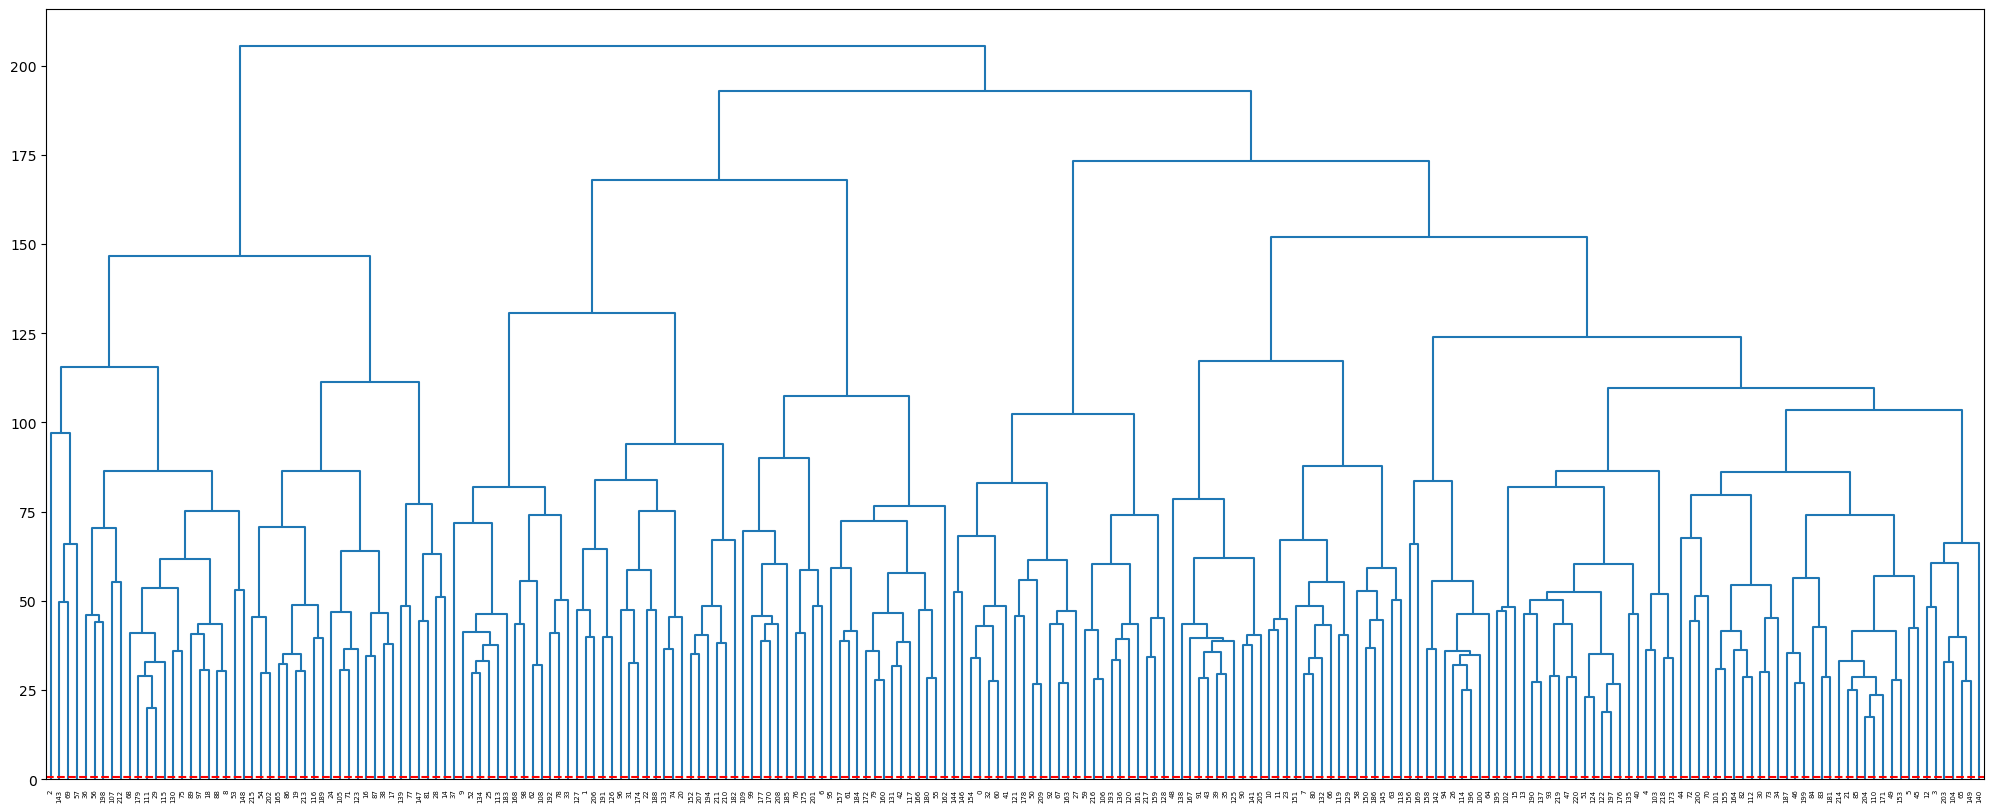

In [73]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

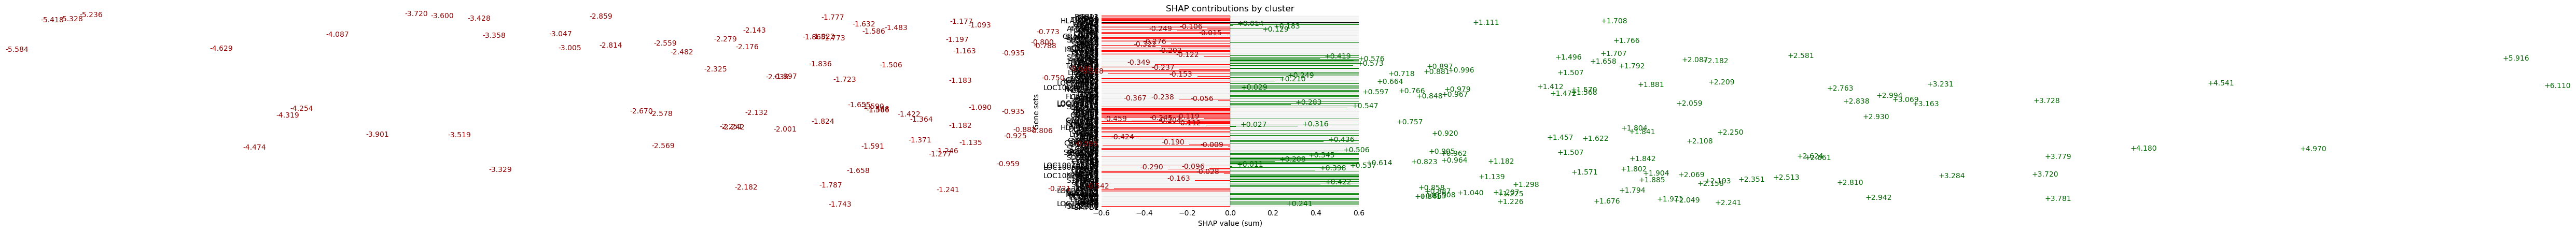

In [74]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [75]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [76]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

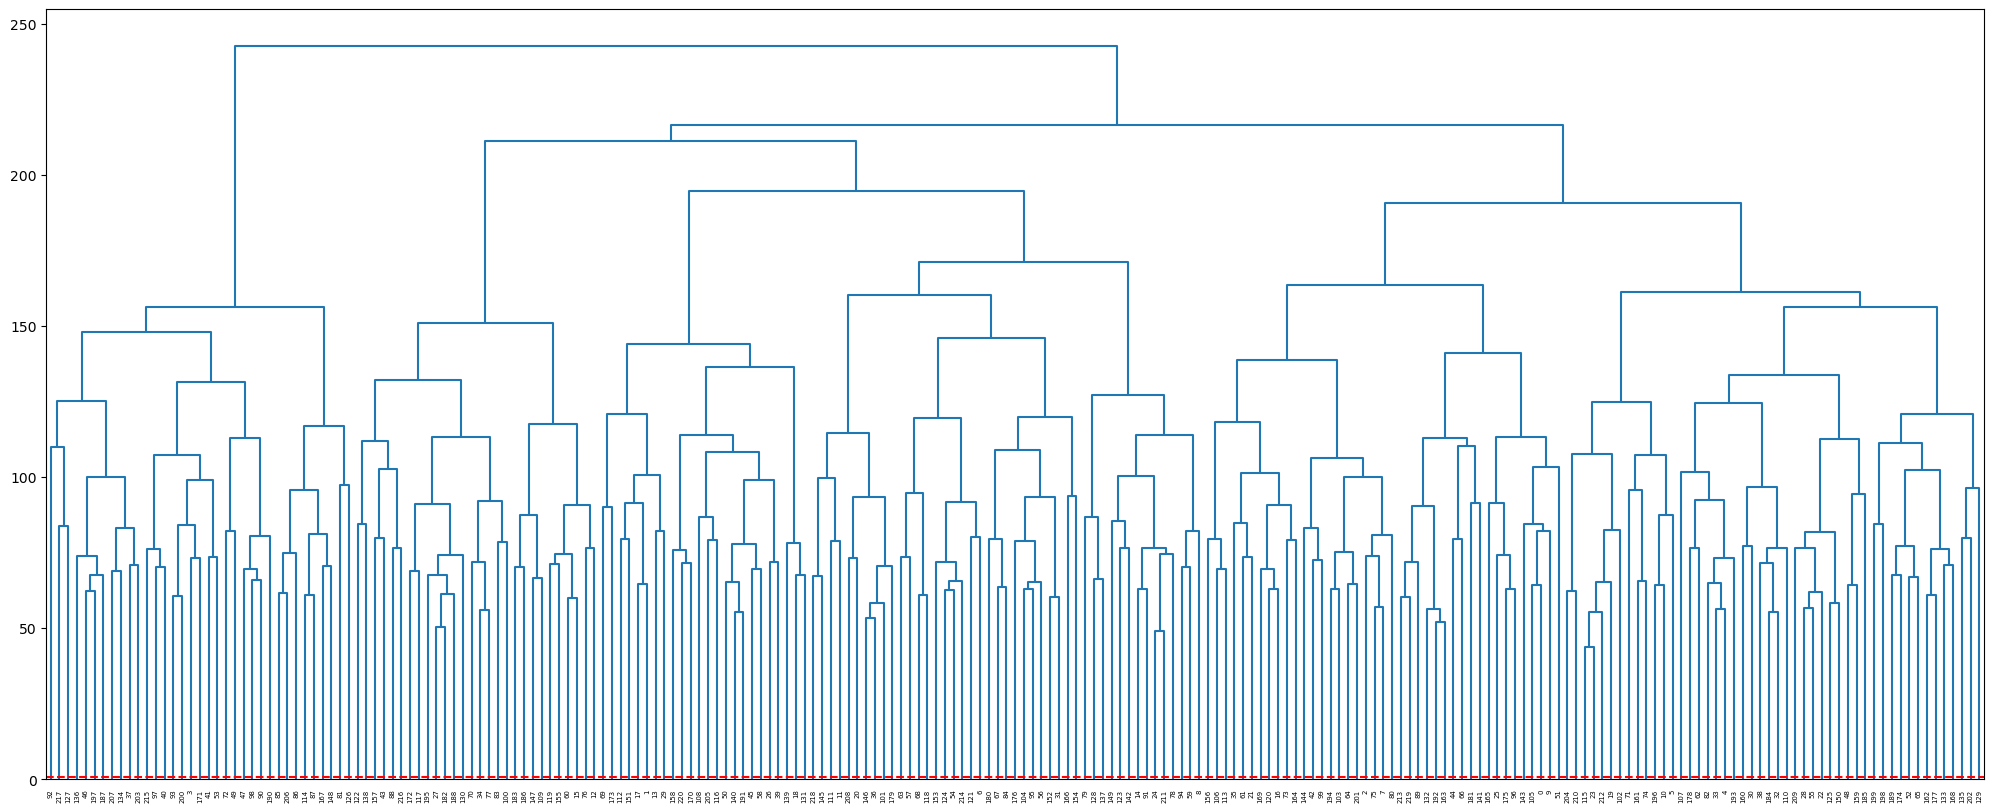

In [77]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = .8)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [78]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 92, 217, 127, 136,  46, 197, 187, 207, 134,  37, 203, 215,  97,
        40,  93, 200,   3, 171,  41,  53,  72,  49,  47,  98,  90, 190,
        85, 206,  86, 114,  87, 167, 148,  81, 126, 122, 138, 157,  43,
        88, 216, 172, 117, 195,  27, 182, 188, 130,  70,  34,  77,  83,
       100, 183, 186, 147, 109, 119, 155,  60,  15,  76,  12,  69, 173,
       112, 151,  17,   1,  13,  29, 158, 220, 170, 108, 205, 116,  50,
       140, 191,  45,  58,  26,  39, 139,  18, 131, 218, 145, 111,  11,
       208,  20, 146,  36, 101, 179,  63,  57,  68, 118, 153, 124,  54,
       214, 121,   6, 180,  67,  84, 176, 104,  95,  56, 152,  31, 166,
       154,  79, 128, 137, 149, 123, 142,  14,  91,  24, 211,  78,  94,
        59,   8, 156, 106, 113,  35,  61,  21, 169, 120,  16,  73, 164,
       144,  42,  99, 194, 103,  64, 201,   2,  75,   7,  80, 213, 219,
        89, 132, 192, 163,  44,  66, 181, 141, 165,  25, 175,  96, 143,
       105,   0,   9,  51, 204, 210, 115,  23, 212,  19, 102,  7

In [79]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'PPP1R17', 'WNT8A', 'LSM5', 'PCDHB3', 'GUSBP11', 'C16orf78', 'C5orf17',
       'LOC100132831', 'LOC100288778', 'LOC100505851'],
      dtype='object', length=221)

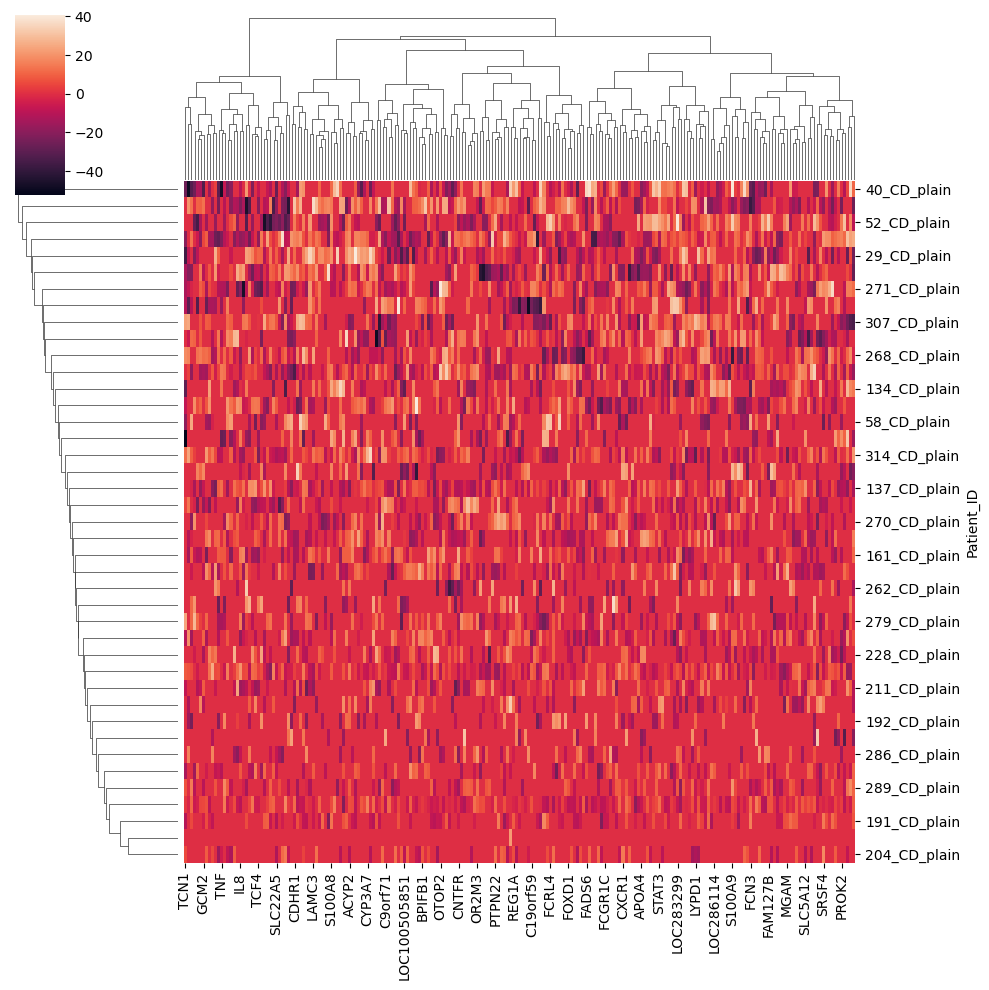

In [80]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [81]:
gene_cluster_cd_plain

array([[115.        ,  23.        ,  43.5913658 ,   2.        ],
       [ 24.        , 211.        ,  49.01064287,   2.        ],
       [ 27.        , 182.        ,  50.21239326,   2.        ],
       [192.        , 163.        ,  52.16068717,   2.        ],
       [146.        ,  36.        ,  53.20627054,   2.        ],
       [140.        , 191.        ,  55.22816217,   2.        ],
       [221.        , 212.        ,  55.38928026,   3.        ],
       [184.        ,  32.        ,  55.46621735,   2.        ],
       [ 34.        ,  77.        ,  56.03981107,   2.        ],
       [ 33.        ,   4.        ,  56.14933601,   2.        ],
       [132.        , 224.        ,  56.21422005,   3.        ],
       [ 28.        ,  55.        ,  56.6054285 ,   2.        ],
       [ 75.        ,   7.        ,  56.84878525,   2.        ],
       [125.        , 150.        ,  58.18020988,   2.        ],
       [225.        , 101.        ,  58.34757326,   3.        ],
       [ 60.        ,  15

In [82]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(221,)

In [83]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([217, 127,  92,  46, 197, 187, 136, 207, 134,  37, 203,  97,  40,
        215,  93, 200,   3, 171,  41,  53,  72,  49,  98,  90,  47, 190,
         85, 206,  86, 114,  87, 167, 148,  81, 126, 122, 138, 157,  43,
         88, 216, 172, 117,  27, 182, 188, 195, 130,  34,  77,  70,  83,
        100, 183, 186, 147, 109, 119, 155,  60,  15,  76,  12,  69, 173,
        112, 151,  17,   1,  13,  29, 220, 170, 158, 205, 116, 108, 140,
        191,  50,  45,  58,  26,  39,  18, 131, 139, 218, 145, 111,  11,
        208,  20, 146,  36, 101, 179,  63,  57,  68, 118, 124,  54, 214,
        153, 121,   6,  67,  84, 180, 104,  95,  56, 176, 152,  31, 166,
        154, 128, 137,  79, 123, 142, 149,  14,  91,  24, 211,  78,  94,
         59,   8, 106, 113, 156,  61,  21,  35, 120,  16, 169,  73, 164,
         42,  99, 144, 194, 103,  64, 201,  75,   7,   2,  80, 213, 219,
         89, 192, 163, 132,  44,  66, 181, 141, 175,  96,  25, 165, 105,
          0,   9, 143,  51, 204, 210, 115,  23, 212

In [84]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [85]:
cluster_labels

array([170,  69, 153,  17, 190, 186, 107, 152, 132, 171, 185,  91,  63,
        70, 125,  61, 140,  68,  85, 179,  93, 137, 202, 177, 127, 167,
        83,  44, 200,  71, 195, 116, 197, 189,  49, 138,  95,  10, 198,
        84,  13,  19, 144,  39, 161,  81,   4,  25, 206,  22,  80, 173,
       213,  20, 103, 201, 113,  99,  82, 131,  60, 136, 188,  98, 149,
       214, 162, 108, 100,  64,  51, 183,  21, 142, 182, 151,  62,  50,
       129, 121, 154,  34, 191,  52, 109,  27,  29,  31,  40, 157,  24,
       126,   3,  15, 130, 112, 166,  12,  23, 145,  53,  96, 180, 148,
       111, 169, 133, 193,  77,  57, 199,  90,  66, 134,  30, 176,  76,
        43, 101,  58, 139, 106,  36, 122, 102, 204,  35,   2, 119, 221,
        48,  86, 160, 217,   9, 219,   7, 120,  37,  87,  78, 164, 123,
       172, 146,  89,  94,  56,  33, 124, 205,  67, 115, 105, 118,  59,
       135,  38,  74, 207, 194, 181, 215, 159, 143, 168, 117,  32, 218,
       141,  73,  18,  42,  65, 212, 165, 114, 216, 187,  97, 11

In [86]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,-0.092988,9.081624,-19.947884,-4.620924,0.0,0.000000,23.214865,AADAC,170
APOA1,41.0,-2.264539,10.803040,-27.701196,-11.311514,0.0,0.000000,21.169489,APOA1,69
APOA4,41.0,-0.804526,10.732186,-21.864996,-5.742915,0.0,0.000000,22.323928,APOA4,153
APOB,41.0,0.342683,9.220570,-20.391316,0.000000,0.0,0.000000,28.186755,APOB,17
APOC3,41.0,0.329269,7.218934,-25.807674,0.000000,0.0,0.000000,17.494429,APOC3,190
...,...,...,...,...,...,...,...,...,...,...
C16orf78,41.0,1.305484,10.270117,-26.241747,0.000000,0.0,2.016648,24.363598,C16orf78,41
C5orf17,41.0,-0.797548,13.567669,-48.499272,-2.427062,0.0,0.000000,24.441842,C5orf17,1
LOC100132831,41.0,-0.487208,11.104336,-37.477070,-7.500972,0.0,5.684119,26.881972,LOC100132831,88
LOC100288778,41.0,3.087272,10.928169,-23.171329,0.000000,0.0,8.481705,29.268712,LOC100288778,156


In [87]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-0.092988,170,AADAC
APOA1,-2.264539,69,APOA1
APOA4,-0.804526,153,APOA4
APOB,0.342683,17,APOB
APOC3,0.329269,190,APOC3
...,...,...,...
C16orf78,1.305484,41,C16orf78
C5orf17,-0.797548,1,C5orf17
LOC100132831,-0.487208,88,LOC100132831
LOC100288778,3.087272,156,LOC100288778


In [88]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-0.092988,170,AADAC
APOA1,-2.264539,69,APOA1
APOA4,-0.804526,153,APOA4
APOB,0.342683,17,APOB
APOC3,0.329269,190,APOC3
...,...,...,...
C16orf78,1.305484,41,C16orf78
C5orf17,-0.797548,1,C5orf17
LOC100132831,-0.487208,88,LOC100132831
LOC100288778,3.087272,156,LOC100288778


In [89]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-0.797548,1,[C5orf17]
2,-0.370129,1,[NAT8B]
3,-3.999831,1,[TCN1]
4,-1.934667,1,[IL10RB]
5,0.401438,1,[DACT3]
...,...,...,...
217,-2.577954,1,[PROK2]
218,-2.796955,1,[MUC5B]
219,2.250767,1,[AGXT2]


In [90]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-0.797548,1,[C5orf17],C5orf17
2,-0.370129,1,[NAT8B],NAT8B
3,-3.999831,1,[TCN1],TCN1
4,-1.934667,1,[IL10RB],IL10RB
5,0.401438,1,[DACT3],DACT3
...,...,...,...,...
217,-2.577954,1,[PROK2],PROK2
218,-2.796955,1,[MUC5B],MUC5B
219,2.250767,1,[AGXT2],AGXT2


In [91]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [92]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
3,-0.797548,1,[C5orf17],C5orf17
1,-0.370129,1,[NAT8B],NAT8B
2,-3.999831,1,[TCN1],TCN1
7,-1.934667,1,[IL10RB],IL10RB
4,0.401438,1,[DACT3],DACT3
...,...,...,...,...
217,-2.577954,1,[PROK2],PROK2
218,-2.796955,1,[MUC5B],MUC5B
219,2.250767,1,[AGXT2],AGXT2
220,2.073184,1,[GRAMD1A],GRAMD1A


In [93]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.370129,1,[NAT8B],NAT8B
2,-3.999831,1,[TCN1],TCN1
3,-0.797548,1,[C5orf17],C5orf17
4,0.401438,1,[DACT3],DACT3
5,-1.215969,1,[GCM2],GCM2
...,...,...,...,...
217,-2.577954,1,[PROK2],PROK2
218,-2.796955,1,[MUC5B],MUC5B
219,2.250767,1,[AGXT2],AGXT2
220,2.073184,1,[GRAMD1A],GRAMD1A


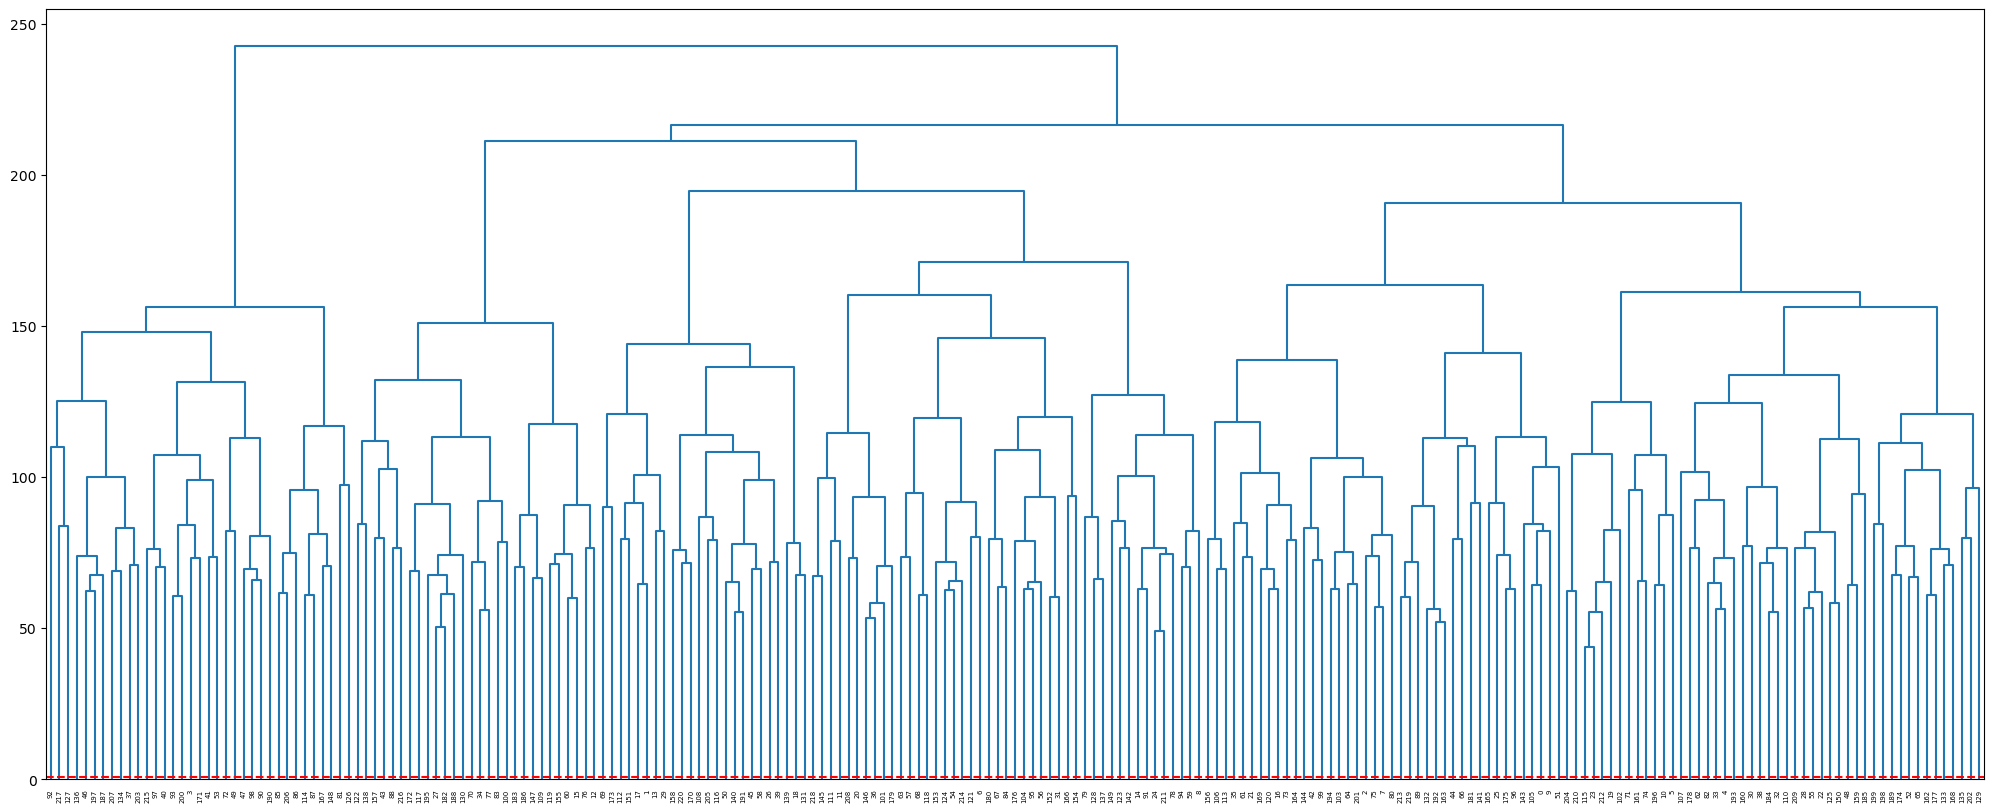

In [94]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

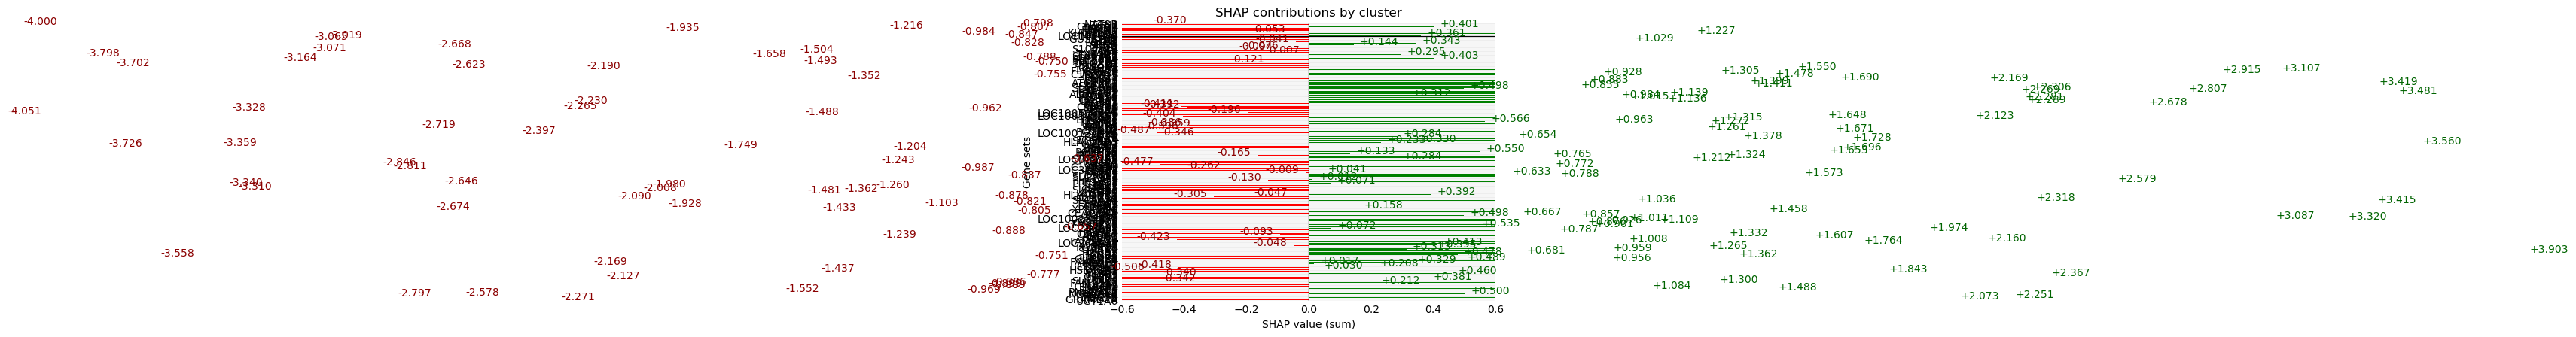

In [95]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [96]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")